In [12]:
import torch
import matplotlib.pyplot as plt

In [17]:
num_particles = 1000
Nx, Ny = 100, 100  # Numero di nodi in x e y
Lx, Ly = 1.0, 1.0  # Dimensioni del dominio
dx, dy = Lx / Nx, Ly / Ny  # Passo della griglia

dt = 0.1
simulation_time = 10

q = 1
m = 1

grid = torch.zeros((Nx, Ny, 2))
particles_position = torch.random.rand((Nx, Ny))

AttributeError: module 'torch.random' has no attribute 'rand'

In [ ]:
def update(positions, velocities):
    density = charge_density(positions)
    E = electric_field(density)
    forces = q * E
    velocities += forces * dt / m
    positions += velocities * dt
    return positions, velocities

In [ ]:
steps = int(simulation_time / dt)

for step in range(steps):
    

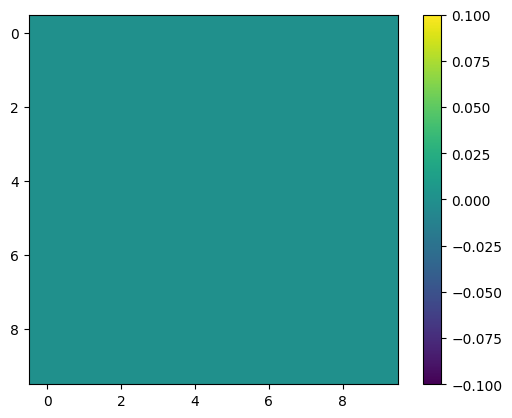

In [15]:
plt.imshow(grid.cpu().numpy()[:, :, 0])
plt.colorbar()
plt.show()

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

# Parametri
num_particles = 1000
num_grid_points = 100
dx = 1.0
dt = 0.01
q = 1.0  # Carica
m = 1.0  # Massa

# Inizializzazione particelle
positions = jnp.linspace(0, dx * num_grid_points, num_particles)
velocities = jnp.zeros_like(positions)

# Densità su griglia
def charge_density(positions):
    grid = jnp.zeros(num_grid_points)
    for p in positions:
        idx = int(p // dx)
        grid = grid.at[idx % num_grid_points].add(q)
    return grid / dx

# Campo elettrico da equazione di Poisson
def electric_field(density):
    # Solve Poisson: dE/dx = rho/epsilon_0
    E = jnp.cumsum(density) * dx
    return E

# Evoluzione temporale
@jit
def update(positions, velocities):
    density = charge_density(positions)
    E = electric_field(density)
    forces = q * E
    velocities += forces * dt / m
    positions += velocities * dt
    return positions, velocities

# Simulazione
for step in range(100):
    positions, velocities = update(positions, velocities)

print("Final positions:", positions)


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape float32[]
The problem arose with the `int` function. If trying to convert the data type of a value, try using `x.astype(int)` or `jnp.array(x, int)` instead.
The error occurred while tracing the function update at C:\Users\marco\AppData\Local\Temp\ipykernel_22056\1837307328.py:32 for jit. This concrete value was not available in Python because it depends on the value of the argument positions.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError